In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

import tensorflow_model_optimization as tfmot

## Load and preprocess training and testing dataset

In [ ]:
data= pd.read_csv("res.csv") 

In [ ]:
data.head()

,one,two,three,four,five,six,seven,eight,cls
0,96,27,114,69,93,78,23,52,0
1,109,30,116,73,93,83,19,47,0
2,107,30,118,73,99,80,22,52,0
3,107,36,115,73,94,82,11,47,0
4,109,33,116,71,99,70,13,44,0


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

In [ ]:
train_data = train_data.reset_index(drop=True)
train_features = train_data.copy()
train_labels = train_features.pop("cls")
test_data = test_data.reset_index(drop=True)
test_features = test_data.copy()
test_labels = test_features.pop("cls")

In [ ]:
train_features

,one,two,three,four,five,six,seven,eight
0,89,18,88,145,129,70,0,38
1,113,32,112,79,95,67,20,56
2,100,0,69,102,82,49,12,41
3,77,0,5,50,53,53,43,61
4,93,10,153,150,110,38,13,42
...,...,...,...,...,...,...,...,...
2395,57,0,145,121,105,57,41,63
2396,79,0,0,63,89,60,35,62
2397,74,0,0,74,98,68,50,67
2398,102,2,52,88,77,26,8,35


## Load and process training and testing dataset

In [ ]:
# Transfer to nparray
num_classes = 6
train_features = train_features.values.astype("float32")
train_labels_one_hot = to_categorical(train_labels, num_classes, dtype="float32")
test_features = test_features.values.astype("float32")
test_labels_one_hot = to_categorical(test_labels, num_classes, dtype="float32")

In [ ]:
def normalize(x):
    # Normalize the value first
    max_num = np.amax(x)
    x = x / max_num
    x = (x * 255) - 127
    
    return x

In [ ]:
# Normalize the features
train_features = normalize(train_features)
test_features = normalize(test_features)

In [ ]:
print(train_features)

[[ -13.525002 -104.05      -14.800003 ...  -37.75     -127.
   -78.55    ]
 [  17.074997  -86.2        15.800003 ...  -41.574997 -101.5
   -55.6     ]
 [   0.5      -127.        -39.025    ...  -64.524994 -111.7
   -74.725006]
 ...
 [ -32.65     -127.       -127.       ...  -40.299995  -63.25
   -41.574997]
 [   3.050003 -124.45      -60.700005 ...  -93.850006 -116.8
   -82.375   ]
 [ -19.900002 -127.       -123.175    ...  -36.475006  -87.475
   -27.550003]]


## Model define and create

In [ ]:
model = Sequential()

# FC1
model.add(Input(shape=(8,), dtype=tf.float32))
model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))

# FC2
model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))

# FC3
model.add(Dense(6))

In [ ]:
model = tfmot.quantization.keras.quantize_model(model)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8192      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128)               0

## Model training

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
# Training model

# Define optimizer loss function and merics 
model.compile(
    optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# Set training
history = model.fit(
    train_features, train_labels_one_hot, 
    validation_data=(test_features, test_labels_one_hot), batch_size=64,
    verbose=1, epochs=100)

Epoch 1/100
38/38 [==============================] - 3s 18ms/step - loss: 0.4357 - accuracy: 0.8771 - val_loss: 1.3504 - val_accuracy: 0.6517
Epoch 2/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0376 - accuracy: 0.9979 - val_loss: 0.5932 - val_accuracy: 0.7933
Epoch 3/100
38/38 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9967 - val_loss: 0.2421 - val_accuracy: 0.9267
Epoch 4/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0137 - accuracy: 0.9983 - val_loss: 0.0924 - val_accuracy: 0.9850
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.0360 - val_accuracy: 0.9983
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0079 - accuracy: 0.9992 - val_loss: 0.0167 - val_accuracy: 0.9983
Epoch 7/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0068 - accuracy: 0.9996 - val_loss: 0.0084 - val_accuracy: 0.9983
Epoch 8/100


38/38 [==============================] - 0s 4ms/step - loss: 2.9555e-04 - accuracy: 1.0000 - val_loss: 4.9287e-04 - val_accuracy: 1.0000
Epoch 58/100
38/38 [==============================] - 0s 4ms/step - loss: 2.2608e-04 - accuracy: 1.0000 - val_loss: 3.9902e-04 - val_accuracy: 1.0000
Epoch 59/100
38/38 [==============================] - 0s 7ms/step - loss: 1.9912e-04 - accuracy: 1.0000 - val_loss: 4.4469e-04 - val_accuracy: 1.0000
Epoch 60/100
38/38 [==============================] - 0s 7ms/step - loss: 2.7158e-04 - accuracy: 1.0000 - val_loss: 2.6261e-04 - val_accuracy: 1.0000
Epoch 61/100
38/38 [==============================] - 0s 6ms/step - loss: 2.2713e-04 - accuracy: 1.0000 - val_loss: 3.4479e-04 - val_accuracy: 1.0000
Epoch 62/100
38/38 [==============================] - 0s 9ms/step - loss: 2.1526e-04 - accuracy: 1.0000 - val_loss: 2.4041e-04 - val_accuracy: 1.0000
Epoch 63/100
38/38 [==============================] - 0s 8ms/step - loss: 2.4561e-04 - accuracy: 1.0000 - val_los

In [ ]:
model.evaluate(test_features, test_labels_one_hot)

19/19 [==============================] - 0s 2ms/step - loss: 6.9342e-05 - accuracy: 1.0000


[6.934168050065637e-05, 1.0]

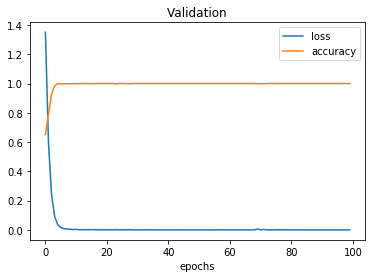

In [ ]:
plt.title("Validation")
plt.plot(history.history["val_loss"], label="loss")
plt.plot(history.history["val_accuracy"], label="accuracy")
plt.xlabel("epochs")
plt.legend()
plt.savefig("valid.pdf")

#Save weights of this model  
model.save_weights('my_model.h5')

#load weights to this TensorFlow model  
model.load_weights('my_model.h5')

In [ ]:
# Save model and weights of this model
model.save("model_save")

INFO:tensorflow:Assets written to: model_save\assets


## Reload and preprocess images in TFLM

## Convert model into TFLM format

In [ ]:
max_samples = len(test_features)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [ ]:
test_features = tf.cast(test_features, tf.float32)
tf_lite_ds = tf.data.Dataset.from_tensor_slices((test_features)).batch(1)

def representative_data_gen():
    for input_value in tf_lite_ds.take(len(tf_lite_ds)):
        yield [input_value]
    
converter.representative_dataset = representative_data_gen

In [ ]:
import pathlib

converter_model = converter.convert()

generated_dir = pathlib.Path("generated/")
generated_dir.mkdir(exist_ok=True, parents=True)
converted_model_file = generated_dir/"pose.tflite"
converted_model_file.write_bytes(converter_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp6k5claql\assets


D:\Anaconda\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


12664

In order to integrate converted model into TFLM application we have to save it as a C array. One way to do that is to use **xxd** utility available on Linux or in Cygwin/MinGW terminals on Windows. Open terminal and run following commands:

```
cd generated/
xxd -i pose.tflite > model.h
```

The model is ready to be integrated into TFLM application.

## Evaluate TensorFlow Lite Model

In [ ]:
import pathlib

generated_dir = pathlib.Path("generated/")
generated_dir.mkdir(exist_ok=True, parents=True)
converted_model_file = generated_dir/"pose.tflite"

interpreter = tf.lite.Interpreter(model_path=str(converted_model_file))
interpreter.allocate_tensors()

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_output_details()[0]["quantization"]

    prediction_values = []
    
    for test_data in test_features:
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_data = np.expand_dims(test_data, axis=0)
        test_data = np.int8(test_data)
        interpreter.set_tensor(input_index, test_data)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
        result = np.argmax(output()[0])
        prediction_values.append(result)
    
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == test_labels[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

Please, keep in mind that full test dataset evaluation on int8 model may take several minutes. 

In [ ]:
print(str(evaluate_model(interpreter)) + "%")

99.83333333333333%


## Create a test set for target application

In [ ]:
import random

# Import training and testing from dataset_buffer
num_of_samples = 25
random_test_features = random.sample(range(1, test_features.shape[0]), num_of_samples)

In [ ]:
samples_file = open("generated/test_samples.cpp", "w")

samples_file.write("#include \"test_samples.h\"\n\n")
samples_file.write("const int kNumSamples = " + str(num_of_samples) + ";\n\n")

samples = "" 
samples_array = "const TestSample test_samples[kNumSamples] = {"

for sample_idx, feature_idx in enumerate(random_test_features, 1):
    feature_arr = list(np.array(test_features[feature_idx]).astype("int"))
    var_name = "sample" + str(sample_idx)
    samples += "TestSample " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
    samples += "\t.label = " + str(test_labels[feature_idx]) + ",\n" 
    samples += "\t.feature = {\n"
    samples += "\t\t" + str(feature_arr)
    samples += "\t}\n};\n\n"    
    samples_array += var_name + ", "
    
samples = samples.replace("[", "")
samples = samples.replace("]", ",\n")
samples_array += "};\n"

samples_file.write(samples);
samples_file.write(samples_array);
samples_file.close()